In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/digit-recognizer/sample_submission.csv
/kaggle/input/digit-recognizer/test.csv
/kaggle/input/digit-recognizer/train.csv


# Additional imports

In [2]:
import tensorflow as tf
from tensorflow import keras

import matplotlib.pyplot as plt
import matplotlib.cm as cm

# Preprocessing

In [3]:
train_data_raw = pd.read_csv('/kaggle/input/digit-recognizer/train.csv')
test_data_raw = pd.read_csv('/kaggle/input/digit-recognizer/test.csv')

print('train_data_shape: ' + str(train_data_raw.shape))
print('test_data_shape: ' + str(test_data_raw.shape))

train_data_shape: (42000, 785)
test_data_shape: (28000, 784)


### Pre processing data

In [4]:
def pre_process_data(dataset, has_label=True):
    if has_label:
        data = dataset.iloc[:,1:].values
    else:
        data = dataset.iloc[:,:].values
        
    data = data.astype(np.float)
    
    data = np.multiply(data, 1.0 / 255.0)
    data = data.reshape(data.shape[:1] + (28, 28, 1))
#     data = data.reshape(dataset.shape[0], 28, 28)
        
    return data

train_images = pre_process_data(train_data_raw)

print(train_images.shape)
print(train_images)

(42000, 28, 28, 1)
[[[[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  ...

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]]


 [[[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  ...

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]]


 [[[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  ...

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0

### Pre processing labels

In [5]:
def pre_process_labels(data):
    labels_flat = data.iloc[:,0].values.ravel()
    num_classes = np.unique(labels_flat).shape[0]
    
    num_labels = labels_flat.shape[0]
    index_offset = np.arange(num_labels) * num_classes
    labels_one_hot = np.zeros((num_labels, num_classes))
    labels_one_hot.flat[index_offset + labels_flat.ravel()] = 1

    return labels_one_hot.astype(np.uint8)

train_labels = pre_process_labels(train_data_raw)

print(train_labels.shape)
print(train_labels)

(42000, 10)
[[0 1 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 [0 1 0 ... 0 0 0]
 ...
 [0 0 0 ... 1 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 1]]


# Showing data

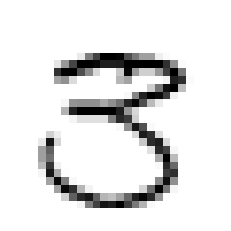

In [6]:
def display(img):
    height = width = int(img.shape[0])

    # (784) => (28,28)
    one_image = img.reshape(width, height)
    
    plt.axis('off')
    plt.imshow(one_image, cmap=cm.binary)

display(train_images[7])

In [7]:
print("Images shape: " + str(train_images.shape))
print("Labels shape: " + str(train_labels.shape))

Images shape: (42000, 28, 28, 1)
Labels shape: (42000, 10)


# Model

In [8]:
def show_history(history):
    fig, ax = plt.subplots(1, 2, figsize=(15,5))
    ax[0].set_title('loss')
    ax[0].plot(history.epoch, history.history["loss"], label="Train loss")
    ax[0].plot(history.epoch, history.history["val_loss"], label="Validation loss")
    ax[1].set_title('acc')
    ax[1].plot(history.epoch, history.history["accuracy"], label="Train acc")
    ax[1].plot(history.epoch, history.history["val_accuracy"], label="Validation acc")
    ax[0].legend()
    ax[1].legend()

In [9]:
def fit(train_images, train_labels, config):
    NUM_EPOCHS = config['NUM_EPOCHS']
    BATCH_SIZE = config['BATCH_SIZE']
    LEARNING_RATE = config['LEARNING_RATE']
    DROPOUT_RATE = config['DROPOUT_RATE']
    NETWORK_WIDTH = config['NETWORK_WIDTH']
    
    initializer = tf.keras.initializers.GlorotNormal()
    
    model = keras.models.Sequential([
        keras.layers.Conv2D(32,kernel_size=(3, 3),activation='swish',kernel_initializer=initializer, input_shape=(28,28,1), use_bias=True),
        keras.layers.Conv2D(32,kernel_size=(3,3), activation='swish',kernel_initializer=initializer, use_bias=True),
        keras.layers.MaxPooling2D(pool_size=(2,2)),
        keras.layers.Dropout(DROPOUT_RATE),
        keras.layers.Conv2D(64,(3, 3),activation='swish', padding='same', use_bias=True),
        keras.layers.MaxPooling2D(pool_size=(2,2)),
        keras.layers.Dropout(DROPOUT_RATE),
        keras.layers.Conv2D(512,(3, 3),activation='swish', padding='same', use_bias=True),
        keras.layers.MaxPooling2D(pool_size=(2,2)),
        keras.layers.Dropout(DROPOUT_RATE),
        keras.layers.Conv2D(256,(2, 2),activation='swish', padding='same', use_bias=True),
        keras.layers.MaxPooling2D(pool_size=(2,2)),
        keras.layers.Dropout(DROPOUT_RATE),
        keras.layers.Flatten(),
        keras.layers.Dense(128,activation='swish', kernel_regularizer =tf.keras.regularizers.l1(l=0.01)),
#         keras.layers.BatchNormalization(),
        keras.layers.Dropout(DROPOUT_RATE),
        keras.layers.Dense(10, activation=tf.nn.softmax),
    ])

    

    
    opt = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)
    loss = tf.keras.losses.CategoricalCrossentropy()

    model.compile(
        optimizer=opt,
        loss=loss,
        metrics=['accuracy']
    )

    
    val_size = int(train_images.shape[0] * 0.2)

    val_images = train_images[:val_size,:, :]
    val_labels = train_labels[:val_size,:]

    train_images = train_images[val_size:,:, :]
    train_labels = train_labels[val_size:,:]

    hist = model.fit(
        x=train_images, y=train_labels,
        epochs=NUM_EPOCHS,
        batch_size=BATCH_SIZE,
        validation_steps=10,
        validation_data=(val_images, val_labels),
        verbose=1
    )
    
    show_history(hist)
    
    loss, acc = model.evaluate(val_images, val_labels)
    
    return model, loss, acc

Epoch 1/50
263/263 [==============================] - 3s 13ms/step - loss: 4.6860 - accuracy: 0.7418 - val_loss: 0.6772 - val_accuracy: 0.9508
Epoch 2/50
263/263 [==============================] - 3s 11ms/step - loss: 0.6712 - accuracy: 0.9265 - val_loss: 0.4977 - val_accuracy: 0.9680
Epoch 3/50
263/263 [==============================] - 3s 11ms/step - loss: 0.5449 - accuracy: 0.9479 - val_loss: 0.4140 - val_accuracy: 0.9844
Epoch 4/50
263/263 [==============================] - 3s 12ms/step - loss: 0.4908 - accuracy: 0.9554 - val_loss: 0.4037 - val_accuracy: 0.9812
Epoch 5/50
263/263 [==============================] - 3s 11ms/step - loss: 0.4538 - accuracy: 0.9619 - val_loss: 0.3489 - val_accuracy: 0.9844
Epoch 6/50
263/263 [==============================] - 3s 11ms/step - loss: 0.4329 - accuracy: 0.9669 - val_loss: 0.3586 - val_accuracy: 0.9797
Epoch 7/50
263/263 [==============================] - 3s 11ms/step - loss: 0.4091 - accuracy: 0.9695 - val_loss: 0.3646 - val_accuracy: 0.9836

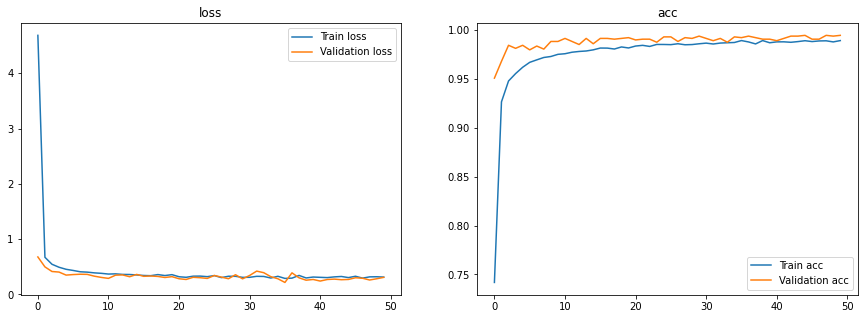

In [10]:
config = {
    'BATCH_SIZE': 128,
    'LEARNING_RATE': 0.001,
    'DROPOUT_RATE': 0.4,
    'NUM_EPOCHS': 50,
    'NETWORK_WIDTH': 512
}

model, loss, acc = fit(train_images, train_labels, config)

print('Accuracy: ' + str(acc * 100) + '%')

# Predicting

In [11]:
test_data = pre_process_data(test_data_raw, False)

test_data.shape

(28000, 28, 28, 1)

In [12]:
predictions = model.predict(test_data)

In [13]:
predictions

array([[1.2291767e-15, 5.2734959e-29, 1.0000000e+00, ..., 4.0491580e-17,
        1.0163348e-19, 1.3959290e-24],
       [9.9999988e-01, 1.8890670e-12, 9.8684938e-10, ..., 4.7466485e-13,
        1.8201284e-08, 6.2172534e-10],
       [3.4409409e-14, 9.7467685e-22, 2.3501975e-16, ..., 1.5148690e-15,
        5.0388704e-11, 1.0000000e+00],
       ...,
       [1.5704966e-25, 1.1061662e-27, 5.6181532e-20, ..., 8.3454397e-23,
        1.4113075e-23, 1.9233529e-26],
       [6.6531893e-12, 5.8766689e-17, 1.5974376e-13, ..., 3.1536603e-12,
        4.9298396e-09, 9.9999893e-01],
       [6.0859799e-16, 1.5458385e-29, 1.0000000e+00, ..., 2.8933170e-17,
        5.9240911e-20, 5.6279418e-25]], dtype=float32)

In [14]:
# submissions for Kaggle
submissions=pd.DataFrame({"ImageId": list(range(1,len(predictions)+1)),
                         "Label": np.argmax(predictions, axis=1)})
submissions.to_csv("my_submissions.csv", index=False, header=True)